In [1]:
import os
import shutil

base_dir = 'C:/Users/parth/Desktop/Ear Detection/dataset_Ear'

output_dir = 'C:/Users/parth/Desktop/Ear Detection/sorted_dataset'
os.makedirs(output_dir, exist_ok=True)

categories = ["Infected", "Normal"]

for category in categories:
    os.makedirs(f"{output_dir}/train/{category}", exist_ok=True)
    os.makedirs(f"{output_dir}/validation/{category}", exist_ok=True)
    os.makedirs(f"{output_dir}/test/{category}", exist_ok=True)

In [2]:
import os
import shutil
import random

train_ = 0.6
validation_ = 0.25
# test_ = 1 - train_ - validation_

def split_data(category):
    category_path = os.path.join(base_dir, category)
    all_images = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

    random.shuffle(all_images) # Random image for each catagory

    num_images = len(all_images)
    num_train = int(num_images * train_)
    num_validation = int(num_images * validation_)
    num_test = num_images - num_train - num_validation

    for i, image in enumerate(all_images):
        image_path = os.path.join(category_path, image)
        if i < num_train:
            shutil.copy(image_path, f"{output_dir}/train/{category}/{image}")
        elif i < num_train + num_validation:
            shutil.copy(image_path, f"{output_dir}/validation/{category}/{image}")
        else:
            shutil.copy(image_path, f"{output_dir}/test/{category}/{image}")

for category in categories:
    split_data(category)

print(f"The dataset was successfully divided into: train ({round(train_*100)}%), test ({round((1 - validation_ - train_) * 100)}%), validation ({round(validation_*100)}%).")


The dataset was successfully divided into: train (60%), test (15%), validation (25%).


In [3]:
import os

def count_images_in_dirs(base_dir, categories, subdirs=['train', 'validation', 'test']):
    for subdir in subdirs:
        print(f"\nCounting images in {subdir} directory:")
        for category in categories:
            category_path = os.path.join(base_dir, subdir, category)
            if os.path.exists(category_path):
                num_images = len([f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))])
                print(f"Category: {category}, Number of images: {num_images}")
            else:
                print(f"Category: {category} not found in {subdir} directory")

base_dir = 'C:/Users/parth/Desktop/Ear Detection/sorted_dataset'

categories = ['Infected', 'Normal']

count_images_in_dirs(base_dir, categories)



Counting images in train directory:
Category: Infected, Number of images: 260
Category: Normal, Number of images: 517

Counting images in validation directory:
Category: Infected, Number of images: 175
Category: Normal, Number of images: 363

Counting images in test directory:
Category: Infected, Number of images: 140
Category: Normal, Number of images: 272


In [4]:
import os

import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LeakyReLU
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.resnet50 import preprocess_input

In [5]:

datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input # resnet50 images preprocess
)

datagen_train = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input, # resnet50 images preprocess
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

train_generator = datagen_train.flow_from_directory(
    'C:/Users/parth/Desktop/Ear Detection/sorted_dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    classes=['Normal', 'Infected']
)

validation_generator = datagen.flow_from_directory(
    'C:/Users/parth/Desktop/Ear Detection/sorted_dataset/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    classes=['Normal', 'Infected']
)

test_generator = datagen.flow_from_directory(
    'C:/Users/parth/Desktop/Ear Detection/sorted_dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    classes=['Normal', 'Infected']
)

Found 777 images belonging to 2 classes.
Found 538 images belonging to 2 classes.
Found 412 images belonging to 2 classes.


In [7]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
for layer in base_model.layers[:-10]:
    layer.trainable = True


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.4)(x)

predictions = Dense(1, activation="sigmoid")(x)
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
model = Model(inputs=base_model.input, outputs=predictions)
# optimizer = Adam(learning_rate=1e-4)
optimizer = SGD(learning_rate=1e-3, momentum=0.9)


In [9]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
class_indices = train_generator.class_indices
print(class_indices)

# balance the weights in Infected and Normal images
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

{'Normal': 0, 'Infected': 1}
Class Weights: {0: 0.7514506769825918, 1: 1.4942307692307693}


In [12]:
def data_generator():
    for image, label in dataset:  # Assuming dataset is an iterable
        yield image, label, None  # Add None for sample_weights


In [14]:
# If you are using a dataset with labeled classes, count them
num_classes = 10  # Example: Change this to match your dataset


In [15]:
dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Images
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32),   # Labels
        tf.TensorSpec(shape=(None,), dtype=tf.float32)  # Sample weights
    )
)


In [18]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=None  # Remove class weights if not used
)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 181s 6s/step - accuracy: 0.5895 - loss: 0.6861 - val_accuracy: 0.6970 - val_loss: 0.5992
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 148s 6s/step - accuracy: 0.7334 - loss: 0.5517 - val_accuracy: 0.7974 - val_loss: 0.5276
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 151s 6s/step - accuracy: 0.7572 - loss: 0.5056 - val_accuracy: 0.7695 - val_loss: 0.4781
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 150s 6s/step - accuracy: 0.7860 - loss: 0.4551 - val_accuracy: 0.7751 - val_loss: 0.4859
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 147s 6s/step - accuracy: 0.8468 - loss: 0.3566 - val_accuracy: 0.8048 - val_loss: 0.4047
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 152s 6s/step - accuracy: 0.8753 - loss: 0.3107 - val_accuracy: 0.8030 - val_loss: 0.4027
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 151s 6s/step - accuracy: 0.8771 - loss: 0.2991 - val_accuracy: 0.8996 - val_loss: 0.2445
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 162s 7s/step - accuracy: 0.9141 - loss: 0.2234 - val_accuracy: 0.8922 - v

In [19]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test group accuracy: {test_accuracy * 100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9094 - loss: 0.1793
Test group accuracy: 91.50%


In [20]:
import json

def save_history_to_json(history, file_path="training_history.json"):
    """
    Save training history to a JSON file.

    Parameters:
    - history: The training history object from the model.
    - file_path: The path to save the JSON file (default: "training_history.json").
    """
    history_dict = history.history  # Extract the history dictionary
    with open(file_path, 'w') as json_file:
        json.dump(history_dict, json_file, indent=4)
    print(f"Training history saved to {file_path}")
save_history_to_json(history, "training_history.json")


Training history saved to training_history.json


In [21]:
def load_history_from_json(file_path="training_history.json"):
    """
    Load training history from a JSON file.

    Parameters:
    - file_path: The path to the JSON file (default: "training_history.json").

    Returns:
    - history_dict: The loaded history dictionary.
    """
    with open(file_path, 'r') as json_file:
        history_dict = json.load(json_file)
    print(f"Training history loaded from {file_path}")
    return history_dict
history = load_history_from_json("training_history.json")


Training history loaded from training_history.json


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..138.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..113.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..63.221].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..138.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..144.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..131.061].
Clipping input data to

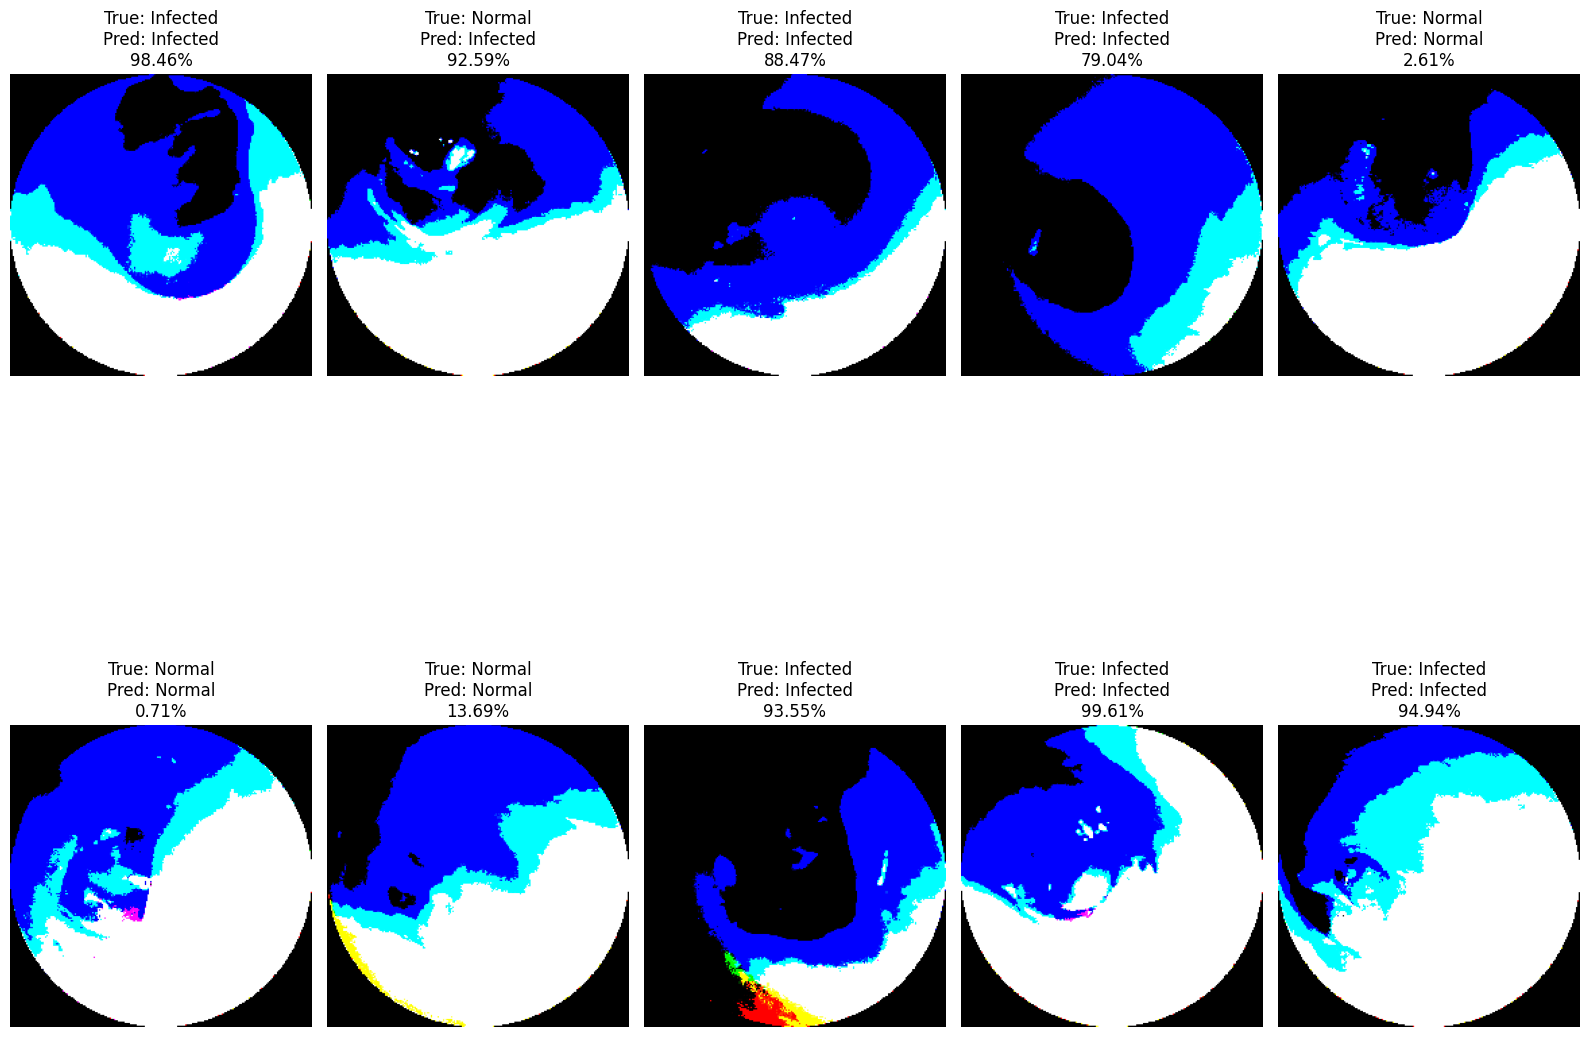

In [22]:
import random
import matplotlib.pyplot as plt
import numpy as np

def evaluate_random_images(model, test_generator, num_images=10):
    all_images, all_labels = [], []

    for i in range(len(test_generator)):
        images, labels = test_generator[i]
        all_images.append(images)
        all_labels.append(labels)

    all_images = np.concatenate(all_images)
    all_labels = np.concatenate(all_labels)

    random_indexes = random.sample(range(all_images.shape[0]), num_images)

    plt.figure(figsize=(16, 16))
    for i, idx in enumerate(random_indexes):
        image = all_images[idx]
        label = all_labels[idx]

        pred_prob = model.predict(np.expand_dims(image, axis=0), verbose=0)
        pred_label = 1 if pred_prob > 0.5 else 0
        pred_percentage = pred_prob[0][0] * 100

        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.title(
            f"True: {'Infected' if label == 1 else 'Normal'}\n"
            f"Pred: {'Infected' if pred_label == 1 else 'Normal'}\n"
            f"{pred_percentage:.2f}%"
        )
        plt.axis('off')

    plt.tight_layout()
    plt.show()

evaluate_random_images(model, test_generator)


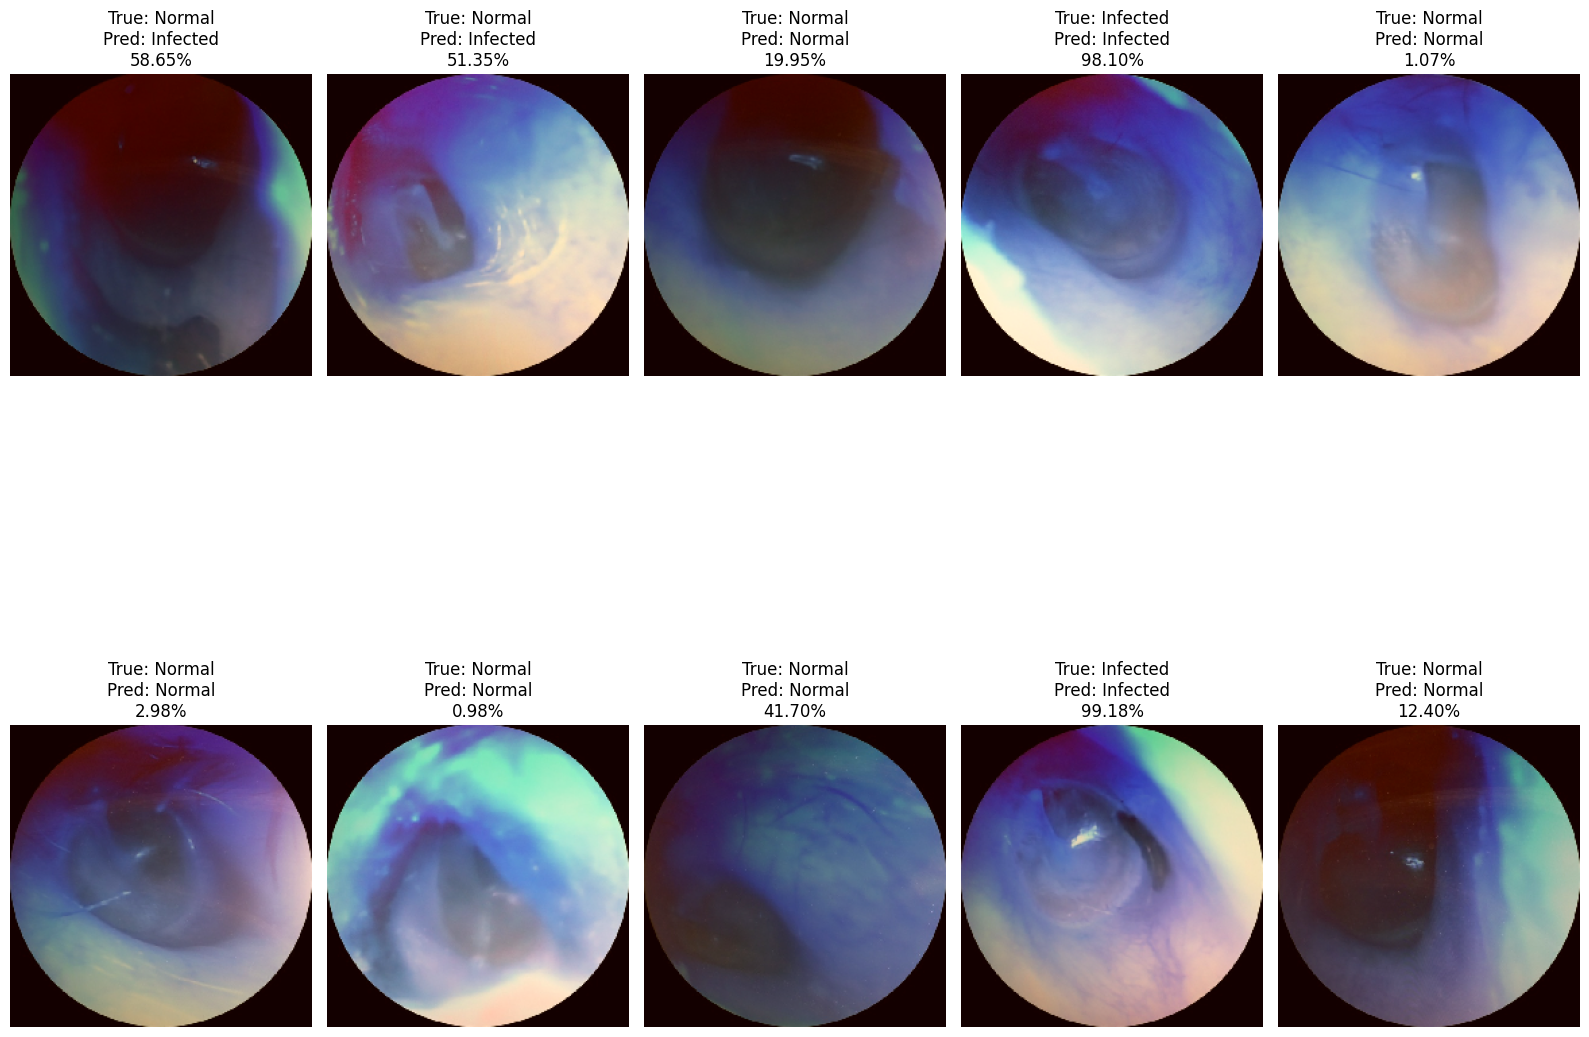

In [23]:
def denormalize_image(image):
    image = image.copy()

    mean = [123.68, 116.779, 103.939]
    std = [1.0, 1.0, 1.0]
    image = image * std + mean
    image = np.clip(image, 0, 255) / 255.0
    return image

def evaluate_random_images(model, test_generator, num_images=10):
    all_images, all_labels = [], []

    for i in range(len(test_generator)):
        images, labels = test_generator[i]
        all_images.append(images)
        all_labels.append(labels)

    all_images = np.concatenate(all_images)
    all_labels = np.concatenate(all_labels)

    random_indexes = random.sample(range(all_images.shape[0]), num_images)

    plt.figure(figsize=(16, 16))
    for i, idx in enumerate(random_indexes):
        image = all_images[idx]
        label = all_labels[idx]

        pred_prob = model.predict(np.expand_dims(image, axis=0), verbose=0)
        pred_label = 1 if pred_prob > 0.5 else 0
        pred_percentage = pred_prob[0][0] * 100

        display_image = denormalize_image(image)

        plt.subplot(2, 5, i + 1)
        plt.imshow(display_image)
        plt.title(
            f"True: {'Infected' if label == 1 else 'Normal'}\n"
            f"Pred: {'Infected' if pred_label == 1 else 'Normal'}\n"
            f"{pred_percentage:.2f}%"
        )
        plt.axis('off')

    plt.tight_layout()
    plt.show()

evaluate_random_images(model, test_generator)


In [42]:
model.save("Ear_Disease_model.h5")

In [38]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true labels and predicted probabilities
y_true = test_generator.classes  # True labels
y_pred_probs = model.predict(test_generator)  # Predicted probabilities

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)  

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)


13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step


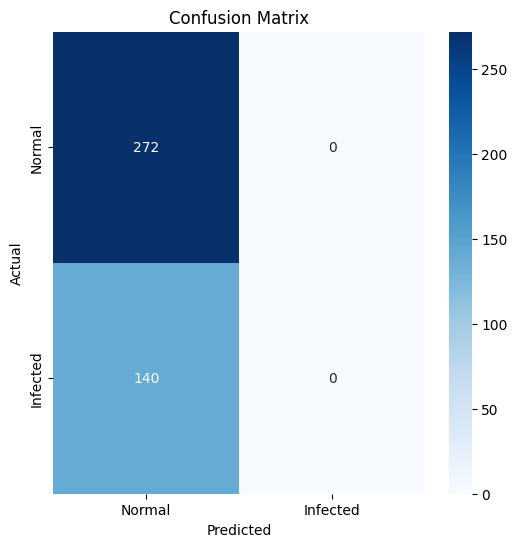

In [39]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


IndexError: index 1 is out of bounds for axis 1 with size 1

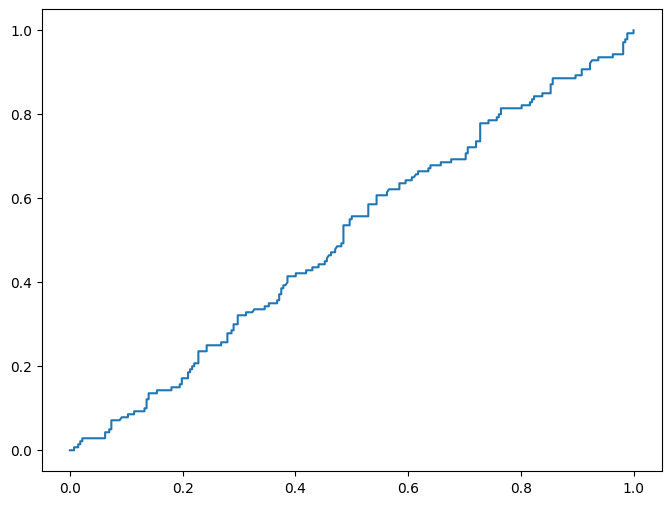

In [40]:
from sklearn.preprocessing import label_binarize

# Convert true labels to one-hot encoding for multi-class ROC
y_true_bin = label_binarize(y_true, classes=np.arange(len(test_generator.class_indices)))

# Compute ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(test_generator.class_indices)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


AttributeError: 'dict' object has no attribute 'history'

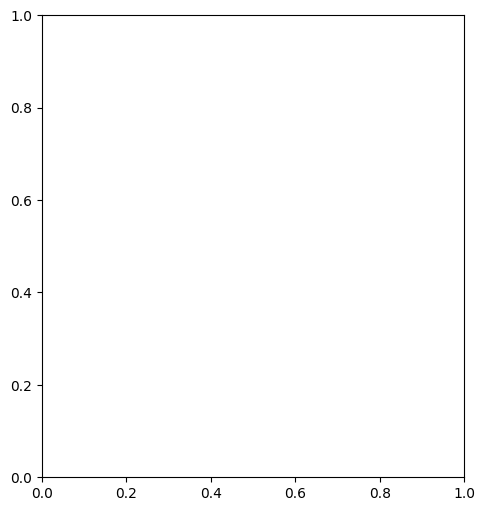

In [41]:
def plot_history(history):
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history.get('val_loss', []), label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot training history
plot_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


C:\Users\parth\AppData\Local\Temp\ipykernel_18256\1122903898.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction > 0.5)]  # Assuming binary classification (0 or 1)


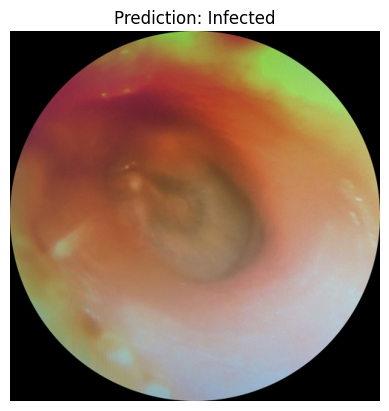

Predicted Class: Infected


In [2]:
import tensorflow as tf
import numpy as np
import cv2
import tkinter as tk
from tkinter import filedialog
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model("Ear_Disease_model.h5")  # Ensure your model is saved

# Labels
class_labels = ['Normal', 'Infected']

# Function to select an image and make a prediction
def predict_image():
    root = tk.Tk()
    root.withdraw()  # Hide the main tkinter window
    file_path = filedialog.askopenfilename(title="Select an Image", filetypes=[("Image Files", "*.jpg;*.jpeg;*.png")])
    
    if not file_path:
        print("No file selected!")
        return
    
    # Load and preprocess the image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))  # Resize to model input size
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)  # Normalize for ResNet50

    # Make prediction
    prediction = model.predict(img)[0]
    predicted_class = class_labels[int(prediction > 0.5)]  # Assuming binary classification (0 or 1)

    # Display image and prediction
    plt.imshow(cv2.imread(file_path)[..., ::-1])  # Convert BGR to RGB for display
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class}")
    plt.show()

    print(f"Predicted Class: {predicted_class}")

# Run the manual testing
predict_image()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


C:\Users\parth\AppData\Local\Temp\ipykernel_14300\1122903898.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction > 0.5)]  # Assuming binary classification (0 or 1)


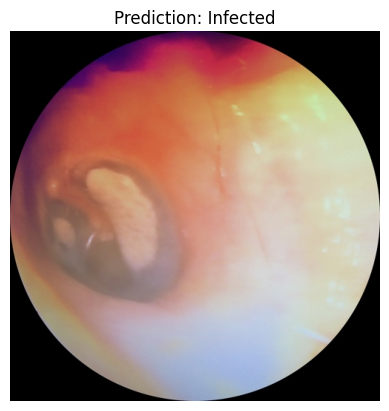

Predicted Class: Infected


In [45]:
import tensorflow as tf
import numpy as np
import cv2
import tkinter as tk
from tkinter import filedialog
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model("Ear_Disease_model.h5")  # Ensure your model is saved

# Labels
class_labels = ['Normal', 'Infected']

# Function to select an image and make a prediction
def predict_image():
    root = tk.Tk()
    root.withdraw()  # Hide the main tkinter window
    file_path = filedialog.askopenfilename(title="Select an Image", filetypes=[("Image Files", "*.jpg;*.jpeg;*.png")])
    
    if not file_path:
        print("No file selected!")
        return
    
    # Load and preprocess the image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))  # Resize to model input size
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)  # Normalize for ResNet50

    # Make prediction
    prediction = model.predict(img)[0]
    predicted_class = class_labels[int(prediction > 0.5)]  # Assuming binary classification (0 or 1)

    # Display image and prediction
    plt.imshow(cv2.imread(file_path)[..., ::-1])  # Convert BGR to RGB for display
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class}")
    plt.show()

    print(f"Predicted Class: {predicted_class}")

# Run the manual testing
predict_image()
